In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import roc_curve,roc_auc_score

## we still have to process the dataset

In [17]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
df = fetch_ucirepo(id=336)
  
# data (as pandas dataframes) 
x = df.data.features 
y = df.data.targets 
  
x.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no


In [18]:
nulls_dict = {'age':[10,42,65,85],'bp':[50,70,78,90],'al':[0,0,2,5],'su':[0,0,0,2],
'bgr':[20,100,150,250],'bu':[9,30,60,120],'sc':[1,3,4,6],'sod':[125,135,140,150],
'pot':[2,4,5,8],'hemo':[5,11,15,18],'pcv':[15,34,44,55],'wbcc':[1000,7000,8500,14500]}

In [19]:
import random

def big_null_deviation_fill(DATAFRAME: pd.DataFrame,DICT:dict) -> pd.DataFrame:
    """"fills the nulls with a random value within the standard deviation ranges
    dict format = 'column':[lower_bound,lower_std,upper_std,upper_std],repeat """

# if float, multiply by 10^n until you have an ints, then process and divide by 10^n
    for i in DICT:
        for w,c in enumerate(DATAFRAME[i].isnull()):
            if c:
                q = random.randint(0,100)
                if q >= 15 and q <= 85:
                    DATAFRAME[i][w] = random.randint(DICT[i][1],DICT[i][2])#/10
                elif q < 15:
                    DATAFRAME[i][w] = random.randint(DICT[i][0],DICT[i][1])#/10
                elif q > 85:
                    DATAFRAME[i][w] = random.randint(DICT[i][2],DICT[i][3])#/10

    return(DATAFRAME)

big_null_deviation_fill(x,nulls_dict)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\1449077709.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  DATAFRAME[i][w] = random.randint(DICT[i][0],DICT[i][1])#/10
C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\1449077709.py:15:

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,101.0,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [20]:
import random

def small_null_deviation_fill(DATAFRAME, COLUMN: str,LOWER_BOUND:int,LOWER_STD:int,UPPER_STD:int,UPPER_BOUND:int):
    """"fills the nulls with a random value within the standard deviation ranges"""

# if float, multiply by 10^n until you have an ints, then process and divide by 10^n

    for w,c in enumerate(DATAFRAME[COLUMN].isnull()):
        if c:
            q = random.randint(0,100)
            if q >= 15 and q <= 85:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_STD,UPPER_STD)/10000
            elif q < 15:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_BOUND,LOWER_STD)/10000
            elif q > 85:
                DATAFRAME[COLUMN][w] = random.randint(UPPER_STD,UPPER_BOUND)/10000

    return(DATAFRAME)

small_null_deviation_fill(x,'sg',10050, 10100, 10200, 10250)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2850801.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  DATAFRAME[COLUMN][w] = random.randint(UPPER_STD,UPPER_BOUND)/10000
C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2850801.py:16

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,101.0,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [21]:
import random

def small_null_deviation_fill(DATAFRAME, COLUMN: str,LOWER_BOUND:int,LOWER_STD:int,UPPER_STD:int,UPPER_BOUND:int):
    """"fills the nulls with a random value within the standard deviation ranges"""

# if float, multiply by 10^n until you have an ints, then process and divide by 10^n

    for w,c in enumerate(DATAFRAME[COLUMN].isnull()):
        if c:
            q = random.randint(0,100)
            if q >= 15 and q <= 85:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_STD,UPPER_STD)/10
            elif q < 15:
                DATAFRAME[COLUMN][w] = random.randint(LOWER_BOUND,LOWER_STD)/10
            elif q > 85:
                DATAFRAME[COLUMN][w] = random.randint(UPPER_STD,UPPER_BOUND)/10

    return(DATAFRAME)

small_null_deviation_fill(x,'rbcc',21, 38, 53, 63)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2165315700.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  DATAFRAME[COLUMN][w] = random.randint(LOWER_STD,UPPER_STD)/10
C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2165315700.py:1

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,101.0,...,11.3,38.0,6000.0,4.0,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,4.0,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [22]:
nb_nulls_dict = {'rbc':'normal','pc':'normal','pcc':'notpresent','ba':'notpresent',
'htn':'no','dm':'no','cad':'no','appet':'good','ane':'no','pe':'no'}

In [23]:
def basic_null_filling(DATAFRAME: pd.DataFrame,NULL_COLUMNS: dict) -> pd.DataFrame:
    """fills in the nulls for all the binary columns"""

    for j in NULL_COLUMNS:
        DATAFRAME[j] = DATAFRAME[j].fillna(NULL_COLUMNS[j])

    return(DATAFRAME)

basic_null_filling(x,nb_nulls_dict)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\2903792610.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAFRAME[j] = DATAFRAME[j].fillna(NULL_COLUMNS[j])


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,normal,normal,notpresent,notpresent,101.0,...,11.3,38.0,6000.0,4.0,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,4.0,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,15.7,47.0,6700.0,4.9,no,no,no,good,no,no
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,16.5,54.0,7800.0,6.2,no,no,no,good,no,no
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,15.8,49.0,6600.0,5.4,no,no,no,good,no,no
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,14.2,51.0,7200.0,5.9,no,no,no,good,no,no


In [24]:
def null_check(DATAFRAME:pd.DataFrame) -> list:

    nulls_list = []

    for i in DATAFRAME:
        for j in DATAFRAME[i].isnull():
            if j:
                if i not in nulls_list:
                    nulls_list.append(i)

    return(nulls_list)

null_check(x)

[]

In [25]:
nb_dict = {'rbc':'abnormal','pc':'abnormal','pcc':'present','ba':'present',
'htn':'yes','dm':'yes','cad':'yes','appet':'poor','ane':'yes','pe':'yes'}


In [26]:
def nb_sort(DATAFRAME: pd.DataFrame,DICT:dict) ->pd.DataFrame:
    """Binary sort a dataframe"""

    for i in DICT:
        nb_sorter = lambda x: 1 if x == DICT[i] else 0

        DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)

    return(DATAFRAME)

nb_sort(x,nb_dict)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\1261725310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,...,15.4,44.0,7800.0,5.2,1,1,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,101.0,...,11.3,38.0,6000.0,4.0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,0,0,0,0,423.0,...,9.6,31.0,7500.0,4.0,0,1,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,0,1,1,0,117.0,...,11.2,32.0,6700.0,3.9,1,0,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,0,0,0,0,106.0,...,11.6,35.0,7300.0,4.6,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,0,0,0,0,140.0,...,15.7,47.0,6700.0,4.9,0,0,0,0,0,0
396,42.0,70.0,1.025,0.0,0.0,0,0,0,0,75.0,...,16.5,54.0,7800.0,6.2,0,0,0,0,0,0
397,12.0,80.0,1.020,0.0,0.0,0,0,0,0,100.0,...,15.8,49.0,6600.0,5.4,0,0,0,0,0,0
398,17.0,60.0,1.025,0.0,0.0,0,0,0,0,114.0,...,14.2,51.0,7200.0,5.9,0,0,0,0,0,0


In [27]:
y_nb = {'class':'ckd'}

In [28]:
def nb_sort(DATAFRAME: pd.DataFrame,DICT:dict) ->pd.DataFrame:
    """Binary sort a dataframe"""

    for i in DICT:
        nb_sorter = lambda x: 1 if x == DICT[i] else 0

        DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)

    return(DATAFRAME)

nb_sort(y,y_nb)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20544\1607186869.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DATAFRAME[i] = DATAFRAME[i].apply(nb_sorter)


,class
0,1
1,1
2,1
3,1
4,1
...,...
395,0
396,0
397,0
398,0


# KNN model

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:238: Data

0.6423248882265276


[0.70625, 0.63125, 0.6, 0.6125, 0.63125, 0.63125, 0.61875, 0.64375, 0.6625]

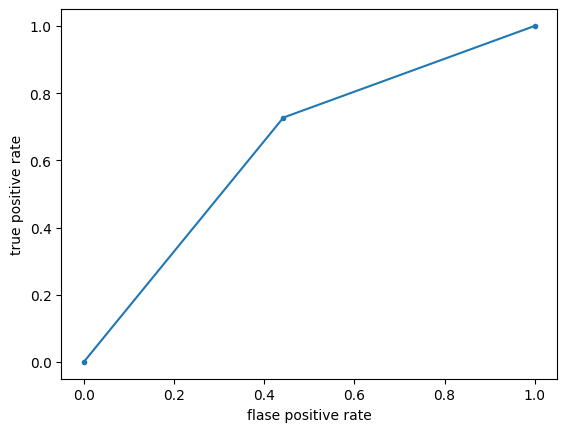

In [45]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

def neighbors_finder(DATAFRAME):
    """This finds the optimal number of neighbors"""
    X = DATAFRAME

    X_train,X_test,y_train,y_test = train_test_split(X,
                                                     y,
                                                     test_size = 0.4,
                                                     random_state=15)
    
    #X_train = StandardScaler().fit_transform(X_train)
    #X_train,y_train = RandomOverSampler().fit_resample(X_train,y_train)

    neighbors = []
    k = 1
    while k <= 17: #oversampling doesnt do anything, stratify makes it worse
        knn = KNeighborsClassifier(n_neighbors=k,weights='distance',algorithm='ball_tree',p=7) #n=2,weights doesnt matter,ball_tree best,p~5-10
        knn.fit(X_train,y_train)
        pred = knn.predict(X_test)
        neighbors.append(knn.score(X_test,y_test))
        k+=2

    #ConfusionMatrixDisplay.from_predictions(y_test,pred)
    fpr,tpr,thresholds = roc_curve(y_test,pred)
    auc = roc_auc_score(y_test,pred)
    print(auc)
    plt.plot(fpr,tpr,marker = '.')
    plt.xlabel('flase positive rate')
    plt.ylabel('true positive rate')   

    return neighbors

neighbors_finder(x)

In [30]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [71]:
knn = KNeighborsClassifier(n_neighbors=2,weights='distance',algorithm='ball_tree',p=7)

In [73]:
def dimentionality_reduction(MODEL)-> int:
    """returns the accuracy of the desired model after dimentionality is applied"""
    steps = [('pca', PCA(n_components=10)), ('m', MODEL)]
    model = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

dimentionality_reduction(knn)
#helps a little

Accuracy: 0.703 (0.058)


# SVC model

In [32]:
from sklearn.svm import SVC

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9618055555555555


0.9583333333333334

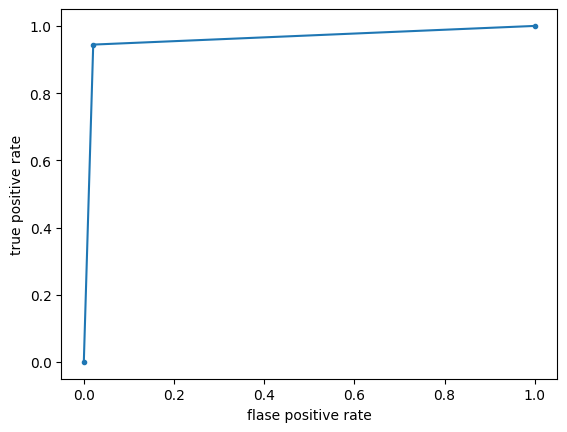

In [70]:
def SVC_ML(DATAFRAME) -> int:
    """ SVC model"""

    classifier = SVC(kernel='linear',C=5) #linear best, c ~3-7, oversampling helps, stratify makes it worse

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.3,random_state=14)

    x_train,y_train = RandomOverSampler().fit_resample(x_train,y_train)
    #x_train = sc.fit_transform(x_train)
    #x_test = sc.fit_transform(x_test)

    classifier.fit(x_train,y_train)
    accuracy = classifier.score(x_test,y_test)
    y_pred = classifier.predict(x_test)
    #ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)
    print(auc)
    plt.plot(fpr,tpr,marker = '.')
    plt.xlabel('flase positive rate')
    plt.ylabel('true positive rate')   


    return(accuracy)

SVC_ML(x)

In [1]:
#classifier = SVC(kernel='linear',C=5)
def dimentionality_reduction(MODEL)-> int:
    """returns the accuracy of the desired model after dimentionality is applied"""
    steps = [('pca', PCA(n_components=10)), ('m', MODEL)]
    model = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

#dimentionality_reduction(classifier)

# Logistic Regression model

0.9421335597057159


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9421335597057159

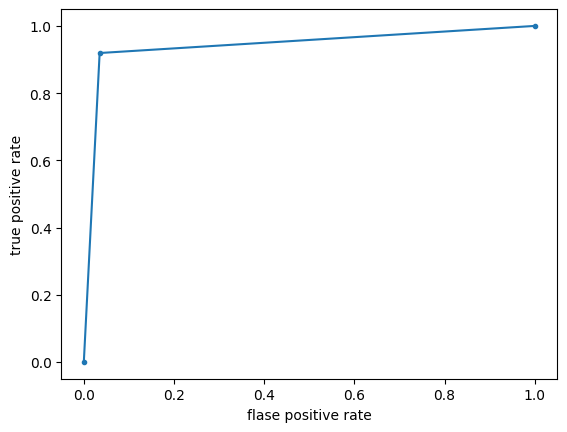

In [69]:
from sklearn.linear_model import LogisticRegression


def logisticregression(DATAFRAME):
    """Just a basic logistic regresison model code"""

    X = DATAFRAME




    X_train,X_test,y_train,y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.25,
                                                    random_state=15,stratify=y)

    #sc = StandardScaler() 
    #X_train = sc.fit_transform(X_train) 
    #X_test = sc.fit_transform(X_test)
    #X_train,y_train = RandomOverSampler().fit_resample(X_train,y_train)

    LogRegression = LogisticRegression(random_state=16,C=10,solver='liblinear').fit(X_train,y_train)

    #c~3-10, liblinear solver solver is best, stratify does help, oversampler makes it worse

    fpr,tpr,thresholds = roc_curve(y_test,LogRegression.predict(X_test))
    auc = roc_auc_score(y_test,LogRegression.predict(X_test))
    print(auc)
    plt.plot(fpr,tpr,marker = '.')
    plt.xlabel('flase positive rate')
    plt.ylabel('true positive rate')   
    return(auc)

logisticregression(x)

In [74]:
def dimentionality_reduction(MODEL)-> int:
    """returns the accuracy of the desired model after dimentionality is applied"""
    steps = [('pca', PCA(n_components=10)), ('m', MODEL)]
    model = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

dimentionality_reduction(LogisticRegression())

Accuracy: 0.860 (0.053)


# Forest model

0.9833333333333333


c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9782608695652174

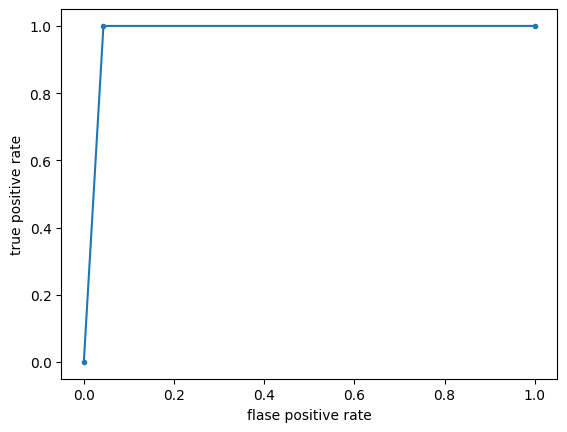

In [65]:
from sklearn.ensemble import RandomForestClassifier


def forest_ml(DATAFRAME:pd.DataFrame)-> int:
    """"basic forest model"""



    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.3,random_state=12,stratify=y)

    x_train,y_train = RandomOverSampler().fit_resample(x_train,y_train)

    forest = RandomForestClassifier(n_estimators=15,random_state=16,criterion='log_loss')
    #estimators~10-20, log_loss best, strafity helps, over sampling helps, modifying other features makes it worse or doesnt do anything
    forest.fit(x_train, y_train)
    print(forest.score(x_test,y_test))
    y_pred = forest.predict(x_test)
    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)
    #print(auc)
    plt.plot(fpr,tpr,marker = '.')
    plt.xlabel('flase positive rate')
    plt.ylabel('true positive rate')   

    return (auc)

forest_ml(x)

In [75]:
forest = RandomForestClassifier(n_estimators=15,random_state=16,criterion='log_loss')

In [76]:
def dimentionality_reduction(MODEL)-> int:
    """returns the accuracy of the desired model after dimentionality is applied"""
    steps = [('pca', PCA(n_components=10)), ('m', MODEL)]
    model = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

dimentionality_reduction(forest)

Accuracy: 0.938 (0.043)


# XGB model

In [38]:
from xgboost import XGBClassifier

0.955


0.9509762308998303

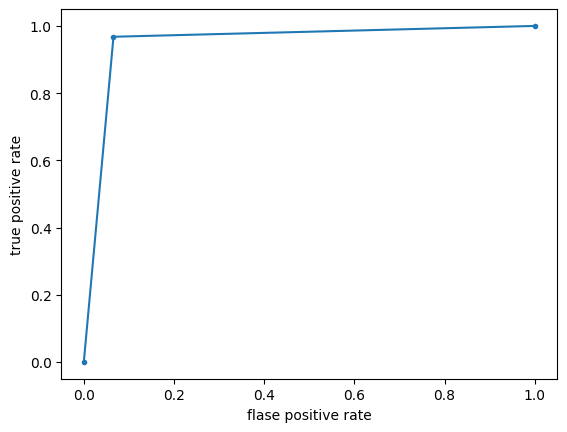

In [52]:
def xgb_ml(DATAFRAME:pd.DataFrame)-> int:
    """xgb model"""

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.5,random_state=11,stratify=y)

    #x_train,y_train = RandomOverSampler().fit_resample(x_train,y_train)

    xgb_model = XGBClassifier()

    xgb_model.fit(x_train,y_train)

    y_pred = xgb_model.predict(x_test)

    print(xgb_model.score(x_test,y_test))

    #oversampling makes it worse, strafity helps, works very well with little modification

    fpr,tpr,thresholds = roc_curve(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)
    #print(auc)
    plt.plot(fpr,tpr,marker = '.')
    plt.xlabel('flase positive rate')
    plt.ylabel('true positive rate')   
    
    return (auc)

xgb_ml(x)

In [77]:
xgb_model = XGBClassifier()

def dimentionality_reduction(MODEL)-> int:
    """returns the accuracy of the desired model after dimentionality is applied"""
    steps = [('pca', PCA(n_components=10)), ('m', MODEL)]
    model = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

dimentionality_reduction(xgb_model)
#makes it worse

Accuracy: 0.930 (0.045)
